Composition du binôme

Prénom, Nom : Léo Pouilly
Prénom, Nom : Clément Briand

Cette Partie 1 du projet apprentissage automatique a pour but de vous faire découvrir et mettre en oeuvre un problème de classification sur des images à l'aide d'un réseau de convolution (structure : couches Conv2D et MaxPooling2D, puis Flatten, et enfin couches Dense).


Les sections du cours en ligne
https://www.oliviergibaru.org/courses/MachineLearning.html
en lien avec l'activité sont

*   Neural Network with Keras : partie Keras CNN example

En fin d'activité, vous decouvrirez un point intéressant pour la suite de votre projet (Partie 2): notion de tranfert d'apprentissage

# Packages utiles et configuration du Drive

In [41]:
import numpy as np
from matplotlib import pyplot as plt
import random

import tensorflow as tf
import keras                                             # bibliothèque Python pour la création de réseaux de neurones (il est contenu dans tensorflow, d'où l'import précédent)
from keras.models import Sequential, Model               # pour créer un modèle (un réseau de neurones) sous Keras
from keras.layers import Dense, Dropout, Activation      # couches classiques d'un réseau dense
from keras.layers import Conv2D, MaxPooling2D,  Flatten  # pour réseau de convolution (si problème traité porte sur des images)
from keras.utils import to_categorical                   # pour mise en format des labels(sorties) dans le cas d'un problème de classification
from sklearn.metrics import confusion_matrix             # outil d'analyse des résultats pour un problème de classification

from keras.datasets import mnist,fashion_mnist           # pour l'importation des jeux de données MNIST et Fashion MNIST (présenté plus loin)


Configuration du Drive

In [42]:
# package utile pour l'utilisation du Drive
import os
from google.colab import drive
from pathlib import Path

# chemin vers le dossier de travail dans le Drive. Vous pouvez le renommer si vous voulez.
working_dir = 'drive/MyDrive/Colab Notebooks/pjt_ml'

def init_drive():
  # point de montage de google drive dans google colab
  drive.mount('drive', force_remount=True)
  # création du dossier de travail si celui-ci n'existe pas
  if not os.path.exists(working_dir):
    os.mkdir(working_dir)

init_drive()

Mounted at drive


# Quelques fonctions utiles fournies


*  **Evolution de l'entrainement** : pour visualiser l'entrainement du réseau, nous avons défini une procédure qui crée et sauvegarde dans le Drive un graphique représentant l'évolution, au cours des époques :
(cas d'un problème de classification) des valeurs de la fonction de perte (loss) et d'accuracy (taux de bonnes prédictions)
pour les données d'entrainement et de test : **summarize_diagnostics_classif(history,directory,filename)**


*  **Matrice de confusion : cm=confusion_matrix(Ylabels,Ypredictions)**.
La diagonale d'un matrice de confusion correspond donc aux bonnes prédictions, et elle permet en particulier de voir si des confusions se produisent plus spécifiquement entre certaines classes.
En recherchant sur internet (par exemple "confusion matrix Keras", "confusion matrix plot"), vous trouverez de nombreux sites sur le sujet, qui vous présentent cet outils et vous montre comment tracer une matrice de confusion et personnaliser ce tracé à vos souhaits. Par exemples :

https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics (section 3.3.2.6)

https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea

https://www.kaggle.com/grfiv4/plot-a-confusion-matrix

Ci-dessous une fonction
**plot_confusion_matrix(cm,target_names,title='Confusion matrix',cmap=None,normalize=False)** permettant de personnaliser le tracé d'une matrice de confusion**

*   **Composition d'un dataset** = Nombre d'occurrences dans
chacune des classes : **OccurencesClasses(Labels,NbClasses)**

*  Visualisation des mauvaises prédictions : **ShowBadPredictions(X,predictions,labels)**.
Cette fonction affiche l'ensemble des images mal prédites avec pour chacune en titre la prédiction P et le vrai label T (T pour True).



In [43]:
def summarize_diagnostics_classif(history,directory,filename):
    # plot loss
    plt.figure(figsize=(8,6))
    plt.subplot(211)
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='test')
    plt.legend()
    # plot accuracy
    plt.subplot(212)
    plt.title('Classification Accuracy')
    plt.plot(history.history['accuracy'], color='blue', label='train')
    plt.plot(history.history['val_accuracy'], color='orange', label='test')
    plt.legend()
    # save plot to file
    plt.savefig("{}/{}_plot.png".format(directory,filename))
    plt.show()
    plt.close()

In [45]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=False):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()


In [25]:
def OccurencesClasses(Labels,NbClasses):
  Occ=np.zeros(NbClasses,int)
  for i in range(len(Labels)):
    Occ[Labels[i]]+=1;
  return(Occ)

In [26]:
def ShowBadPredictions(X,predictions,labels):
  Lerreur=[]
  for i in range(len(labels)):
    if  predictions[i] != labels[i] :
      Lerreur.append(i)
  print('Nombre de prédictions erronées=',len(Lerreur),'')
  print('accuracy=', (len(labels)-len(Lerreur))/len(labels)*100)
  n=int(len(Lerreur)/10)+1
  plt.figure(figsize=(10,2*n))
  for i in range(len(Lerreur)):
    plt.subplot(n,10,i+1)
    ind=Lerreur[i]
    titre='P='+str(predictions[ind])+',T='+str(labels[ind])
    plt.title(titre,fontsize=12)
    plt.imshow(X[ind],cmap="Greys")
    plt.axis("off")
  plt.show()

# Les dataset MNIST et Fashion-MNIST


*   La base de données **MNIST** (pour Modified ou Mixed National Institute of
Standards and Technology)
est une des plus célèbres base de données labelisée d'images. Elle aborde le problème de reconnaissance
automatique de nombres en classification par apprentissage automatique (Machine Learning). Cette
base de données d'images en niveaux de gris, de chiffres écrits "à la main", regroupe 60000 images
d’apprentissage et 10000 images de test. La taille de chaque image est de 28 * 28 = 784 pixels.

*   Sur ce même format (images 28x28 en niveau de gris), de nombreuses variantes de cette célèbre base de données MNIST ont été créées, dont **Fashion MNIST** (base de donnée d'articles Zalando). Fashion MNIST comporte, comme pour la base de données MNIST, 60000 images d'apprentissage et 10000 images de test, en niveaux de gris, de taille 28$\times$28  = 784 pixels, reparties en 10 classes différentes :
[ 0:"T-shirt/top", 1:"Trouser", 2:"Pullover", 3:"Dress", 4:"Coat", 5:"Sandal", 6:"Shirt", 7:"Sneaker", 8:"Bag", 9:"Ankle boot" ].  Comme pour MNIST, les images de cette base de données Fashion  MNIST peuvent etre directement importées depuis KERAS. cette base de données est plus "challenging" que la base de données MNIST.

In [46]:

(XtrainM, YtrainM), (XtestM, YtestM) = mnist.load_data()

# Remarque : pour Fashion_MNIST
(XtrainFM, YtrainFM), (XtestFM, YtestFM) = fashion_mnist.load_data()

print('MNIST')
print('shape xtrain=',XtrainM.shape)
print('shape ytrain=',YtrainM.shape)
print('shape xtest=',XtestM.shape)
print('shape ytest=',YtestM.shape)

print('Fashion MNIST')
print('shape xtrain=',XtrainFM.shape)
print('shape ytrain=',YtrainFM.shape)
print('shape xtest=',XtestFM.shape)
print('shape ytest=',YtestFM.shape)



MNIST
shape xtrain= (60000, 28, 28)
shape ytrain= (60000,)
shape xtest= (10000, 28, 28)
shape ytest= (10000,)
Fashion MNIST
shape xtrain= (60000, 28, 28)
shape ytrain= (60000,)
shape xtest= (10000, 28, 28)
shape ytest= (10000,)


In [47]:
# Nombre d'occurrences dans chacune des 10 classes pour le dataset de Train et de Test
print('Train MNIST :', OccurencesClasses(YtrainM,10))
print('Test MNIST :', OccurencesClasses(YtestM,10))
print('Train Fashion MNIST :', OccurencesClasses(YtrainFM,10))
print('Test Fashion MNIST :', OccurencesClasses(YtestFM,10))
# Nous constatons que le dataset MNIST n'est pas exactement homogène et que Fashion MNIST est homogène

Train MNIST : [5923 6742 5958 6131 5842 5421 5918 6265 5851 5949]
Test MNIST : [ 980 1135 1032 1010  982  892  958 1028  974 1009]
Train Fashion MNIST : [6000 6000 6000 6000 6000 6000 6000 6000 6000 6000]
Test Fashion MNIST : [1000 1000 1000 1000 1000 1000 1000 1000 1000 1000]


Affichage des 50 premières images d'entrainement avec les labels

Des images MNIST


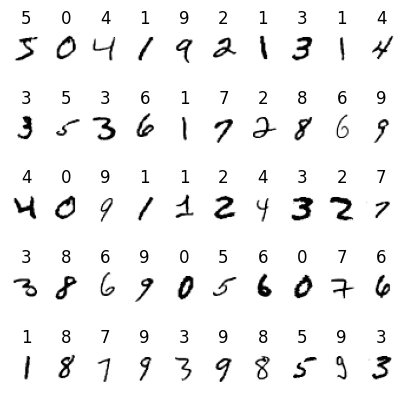

Des images Fashion MNIST


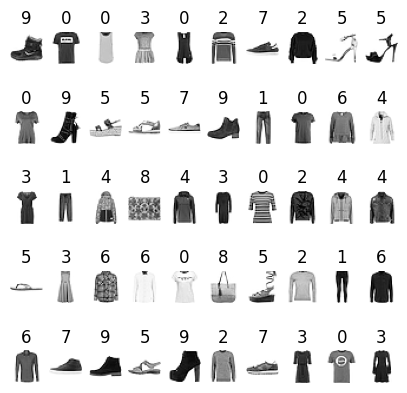

In [48]:
print('Des images MNIST')
plt.figure(figsize=(5,5))
for i in range(50):
  plt.subplot(5,10,i+1)
  plt.title(YtrainM[i])
  plt.imshow(XtrainM[i],cmap="Greys")
  plt.axis("off")
plt.show()

print('Des images Fashion MNIST')
plt.figure(figsize=(5,5))
for i in range(50):
  plt.subplot(5,10,i+1)
  plt.title(YtrainFM[i])
  plt.imshow(XtrainFM[i],cmap="Greys")
  plt.axis("off")
plt.show()

# Projet - Partie 1 - Introduction - Reseau de neurones pour classification supervisée des chiffres "MNIST" ou "Fashion-MNIST (10 classes)

A retenir :
*   **Il convient de diviser (déjà fait dans les dataset considéré) les données labélisées en données de train (model.fit) et données de test (model.predict)** pour vérifier que
l'algorithme / le réseau de neurones
est capable de généraliser à de nouvelles données sur lesquelles il n'a pas été réglé/entrainé. En effet, une bonne accuracy de fit n'est pas forcement synonyme d'un algorithme / réseau de neurones performant !
De l'overfitting a pu se produire. C'est pourquoi, il faut garder des données labélisées pour le test avant d'utiliser cet algorithme / réseau de neurones pour réellement faire des prédictions.

*   **La matrice de confusion est un très bel outil pour analyser les résultats sur ces données de test**.
La diagonale d'une matrice de confusion correspond aux bonnes prédictions (accuracy de test).
Elle permet de voir en plus si des confusions se produisent plus spécifiquement entre certaines classes.



Nous devons "préparer" les données afin qu'elles soient utilisables par Keras.
Ici fait avec MNIST. Vous pourrez le refaire pour Fashion MNIST si vous voulez (en changeant donc M en MF)

In [53]:
# Passage des entrées (images) en tenseur (array à 3 dimensions (nb lignes, nb colonnes, nb canaux) )
# Transformation des labels en sorties du réseau
#---------------------------------------------------------------------------------------

# Ici MNIST. Vous pourrez le refaire pour Fashion MNIST par la suite (en changeant donc M en MF)
Xtrain=np.array(XtrainM);
Xtest=np.array(XtestM);
Ytrain=YtrainM
Ytest=YtestM

print('avant mise en format')
print("Xtrain:"+ str(np.shape(Xtrain)) + " , Ytrain:" + str(np.shape(Ytrain)))
print("Xtest:"+ str(np.shape(Xtest))+ " , Ytest" + str(np.shape(Ytest)))


# Mise en forme des données d'entrée
Xtrain=np.array( Xtrain.reshape((len(Ytrain),28,28,1)) )
Xtest=np.array(  Xtest.reshape((len(Ytest),28,28,1))   )

# Mise en forme des données de sortie
#attention ! : vous devez bien comprendre ce que font ces lignes de code
#              ... et comprendre pourquoi il faudra utiliser Ytest et non Ytest_nn pour la matrice de confusion !
Ytrain_nn = to_categorical(Ytrain)
Ytest_nn = to_categorical(Ytest)

print('après mise en format')
print("Xtrain:"+ str(np.shape(Xtrain)) + " , Ytrain_nn:" + str(np.shape(Ytrain_nn)))
print("Xtest:"+ str(np.shape(Xtest))+ " , Ytest nn:" + str(np.shape(Ytest_nn)))


avant mise en format
Xtrain:(60000, 28, 28) , Ytrain:(60000,)
Xtest:(10000, 28, 28) , Ytest(10000,)
après mise en format
Xtrain:(60000, 28, 28, 1) , Ytrain_nn:(60000, 10)
Xtest:(10000, 28, 28, 1) , Ytest nn:(10000, 10)


**Expliquez la mise en format des données**

*>* **La mise en format est le passage à un format "tenseur", où l'on passe d'une matrice à 1 dimension, à un tenseur qui possède plusieurs dimensions. Grâce à la fonction to_categorical. En effet, cette fonction to_categorical est utilisée pour convertir des entiers représentants des classes en un vecteur colonne où un seul élément est activé. Par exemple : pour y = 3, la fonction to_categorical transformera ceci en y = transposée([0,0,0,1,0,0,0,...,0])**



Création d'un reseau de neurones convolutifs pour la classification supervisée d'images : partie **# A COMPLETER #**

Il faut donc s'approcher au plus proche de la structure demandée.

Vous pouvez vous inspirer de l'exemple en ligne
https://www.oliviergibaru.org/courses/ML_Keras.html#CNN

Si vos données d'entrées sont des images, la structure principale du réseau doit être :  couches de convolution (+ éventuellement DropOut, MaxPooling)  / flatten / couches denses (+ éventuellement DropOut).

La couche de sortie doit contenir autant de neurones qu'il y a de classes, avec une fonction d'activation softmax.

Nous allons prendre le temps d'expliquer chacune de ces couches et la fonction d'activation "softmax".

Nous pouvons en outre extraire à partir du réseau entrainé des caractéristiques (données "numériques") d'une image en "coupant le réseau après une des couches denses" (point évoqué au dessus). Dans ce but nous allons nommé la couche dense avant la couche de sortie. Pour cela il suffit de rajouter l'argument name='...' dans la couche concernée.

*   Pour la fonction de loss et la métrique, nous choisissons " : 'categorical_crossentropy' https://keras.io/api/losses/
    et 'Adam' pour optimizer : https://keras.io/api/optimizers/


In [54]:
ModelClassifImage = Sequential()

ModelClassifImage = Sequential()
ModelClassifImage.add(Conv2D(16, kernel_size=(5, 5), strides=(1, 1), activation='relu', input_shape=(28,28,1)))
ModelClassifImage.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
ModelClassifImage.add(Conv2D(32, (3, 3), activation='relu'))
ModelClassifImage.add(MaxPooling2D(pool_size=(2, 2)))
ModelClassifImage.add(Conv2D(32, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
ModelClassifImage.add(Flatten())
ModelClassifImage.add(Dense(100, activation='relu', name='Briand'))
ModelClassifImage.add(Dense(40, activation='relu', name='Pouilly'))
ModelClassifImage.add(Dense(10, activation='softmax'))

# compile model
ModelClassifImage.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
ModelClassifImage.summary() # permet d'afficher l'architecture du réseaux, les noms et dimensions des couches, le nombre de paramètres du réseau.

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 16)          │             416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 12, 12, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 10, 10, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 5, 5, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 3, 3, 32)            │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 288)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Briand (Dense)                       │ (None, 100)                 │          28,900 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Pouilly (Dense)                      │ (None, 40)                  │           4,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 10)                  │             410 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 47,654 (186.15 KB)

 Trainable params: 47,654 (186.15 KB)

 Non-trainable params: 0 (0.00 B)

Entraînement du reseau (cela prend un peu de temps) et sauvegarde des poids du réseau entraîné

*>* **Réponse à là Q3 : La convolution est une opération mathématique qui consiste à appliquer un filtre sur une image ou un ensemble de données. Ce filtre fait défiler l'image pixel par pixel, et à chaque position, il effectue une multiplication élément par élément suivie d'une somme. Cela permet d'extraire des caractéristiques locales, comme des bords, des textures et des motifs spécifiques.**

**Le max pooling est une opération de réduction de dimension, qui consiste à diviser l'image en petites sections (exemple: des fenêtres de 2x2 pixels), puis à sélectionner le maximum de chaque section. Cela permet de réduire la taille de l'image tout en conservant les informations les plus importantes pour éviter le sur-apprentissage.**

**Explication de la première couche de convolution :**      
**- (5,5) signifie que le filtre à une taille de 5*5 pixels**
**- (1,1) indique que le filtre se déplace de 1 pixel à la fois, horizontalement et verticalement.**
**- taille de sortie = ((taille de l'entrée - taille du noyau)/strides) + 1
d'où ici la taille de sortie qui vaut 24**

**Explication de la première couche de MaxPooling**
**- pool size (2,2) signifie que l'on applique un filtre de 2*2 pixels**
**- strides (2,2) est encore une fois lié au déplacement, la taille sera donc divisée par deux, on aura une taille de sortie de 12*12 pixels avec 16 canaux (12,12,16)**

**Explication de flatten:**

**Après la dernière couche de convolution, le modèle a une sortie 3D de forme (3, 3, 32), qui est aplatie (flattened) en un vecteur de taille 3 * 3 * 32 = 288. La couche Flatten() transforme cette forme en un vecteur unidimensionnel de taille 288.**

**Explication Dense:**
**100 : Cette couche dense contient 100 neurones. Chaque neurone reçoit une entrée de tous les neurones de la couche précédente.**




Une fois l'entrainement fait (et concluant) et la matrice de confusion obtenue, changer la variable ci-dessous "Entrainement" en False, en vue de la prochaine séance.
Le jeu de poids sauvegardé lors de l'entrainement, sera alors chargé (à la place de relancer un entrainement qui prendra du temps et aboutira en plus à des résultats différents).

In [55]:
Entrainement=True

if Entrainement :
  history = ModelClassifImage.fit(Xtrain,Ytrain_nn, epochs=10, batch_size=64,
                    validation_data=(Xtest,Ytest_nn), verbose=1)

Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.7766 - loss: 1.8187 - val_accuracy: 0.9699 - val_loss: 0.0982
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9720 - loss: 0.0979 - val_accuracy: 0.9746 - val_loss: 0.0768
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9799 - loss: 0.0653 - val_accuracy: 0.9823 - val_loss: 0.0503
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9860 - loss: 0.0469 - val_accuracy: 0.9761 - val_loss: 0.0807
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9865 - loss: 0.0444 - val_accuracy: 0.9802 - val_loss: 0.0620
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9877 - loss: 0.0390 - val_accuracy: 0.9839 - val_loss: 0.0578
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9890 - loss: 0.0358 - val_accuracy: 0.9804 - val_loss: 0.0734
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9899 - loss: 0.0344 - val_accuracy: 

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9804 - loss: 0.0643
> 98.420


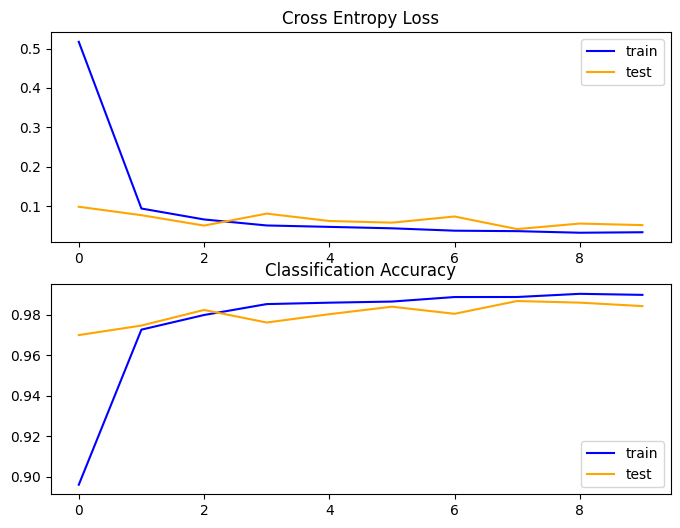

In [56]:
#choisir le nom du fichier de poids qui sera sauvegardé dans le Drive
filename="Partie2Q5"
# Si vous relancez pour Fashion MNIST, il faut penser à changer le nom pour ne pas écraser le jeu de poids du réseau pour MNIST

if Entrainement :
  # evaluate model
  _, acc = ModelClassifImage.evaluate(Xtest,Ytest_nn)
  print('> %.3f' % (acc * 100.0))
  # save model parameters
  ModelClassifImage.save_weights("{}/{}.weights.h5".format(working_dir,filename))
  # learning curves
  summarize_diagnostics_classif(history,working_dir,filename)

else:
  # load model parameters
  filename="MNIST"
  ModelClassifImage.load_weights("{}/{}.weights.h5".format(working_dir,filename))


Predictions et matrice de confusion

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
classe:   0 0.9888663967611336
classe:   1 0.9955908289241623
classe:   2 0.9634489222118088
classe:   3 0.993963782696177
classe:   4 0.9664031620553359
classe:   5 0.9811320754716981
classe:   6 0.9957537154989384
classe:   7 0.9871541501976284
classe:   8 0.9794450154162384
classe:   9 0.9907881269191402


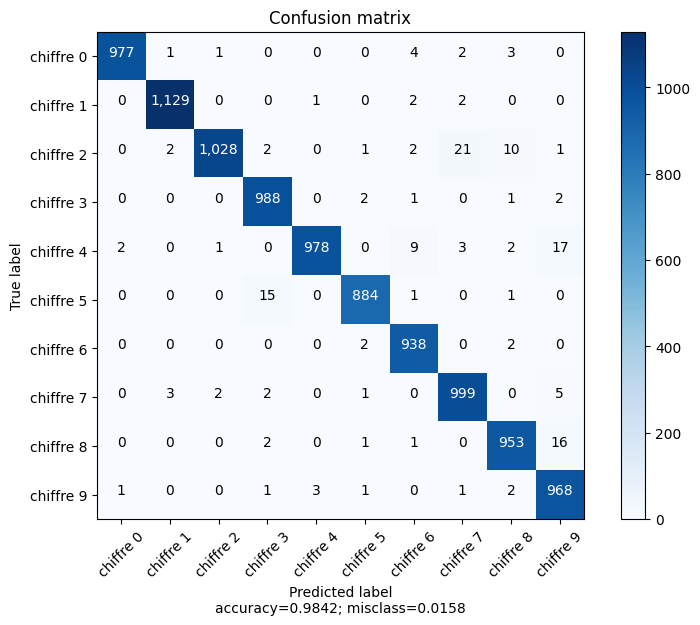

In [57]:
# Prédictions sur les données de test et  matrice de confusion
y_pred=ModelClassifImage.predict(Xtest)
Y_pred = np.argmax(y_pred, 1) # Expliquez(commentez) ce point

cm=confusion_matrix(Y_pred,Ytest)

# MNIST
name_classes=['chiffre 0','chiffre 1','chiffre 2','chiffre 3','chiffre 4',
                  'chiffre 5','chiffre 6','chiffre 7','chiffre 8','chiffre 9']


# remarque : de même pour Fashion MNIST, nous pouvons nommer les classes
#name_classes=['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
#                'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
L = []
for i in range (len(cm)):
  L.append(cm[i][i]/sum(cm[i][j] for j in range (len(cm))))
  print('classe:  ',i,  L[-1])



Mytitle='Confusion matrix'
Mycmap='Blues'    #personnalisation de la couleur : https://matplotlib.org/2.0.2/examples/color/colormaps_reference.html  (par défaut = Blues)
plot_confusion_matrix(cm,target_names=name_classes,title=Mytitle,cmap=Mycmap,normalize=False)
# normalize : 'False' = résultat en nombre d'occurences , 'True' = resultat en proportion pour chaque classe

In [ ]:
cm[7][2]

8

**Accuracy pour chacune des classes : A compléter dans la cellule de code ci-dessous**

Nombre de prédictions erronées= 158 
accuracy= 98.42


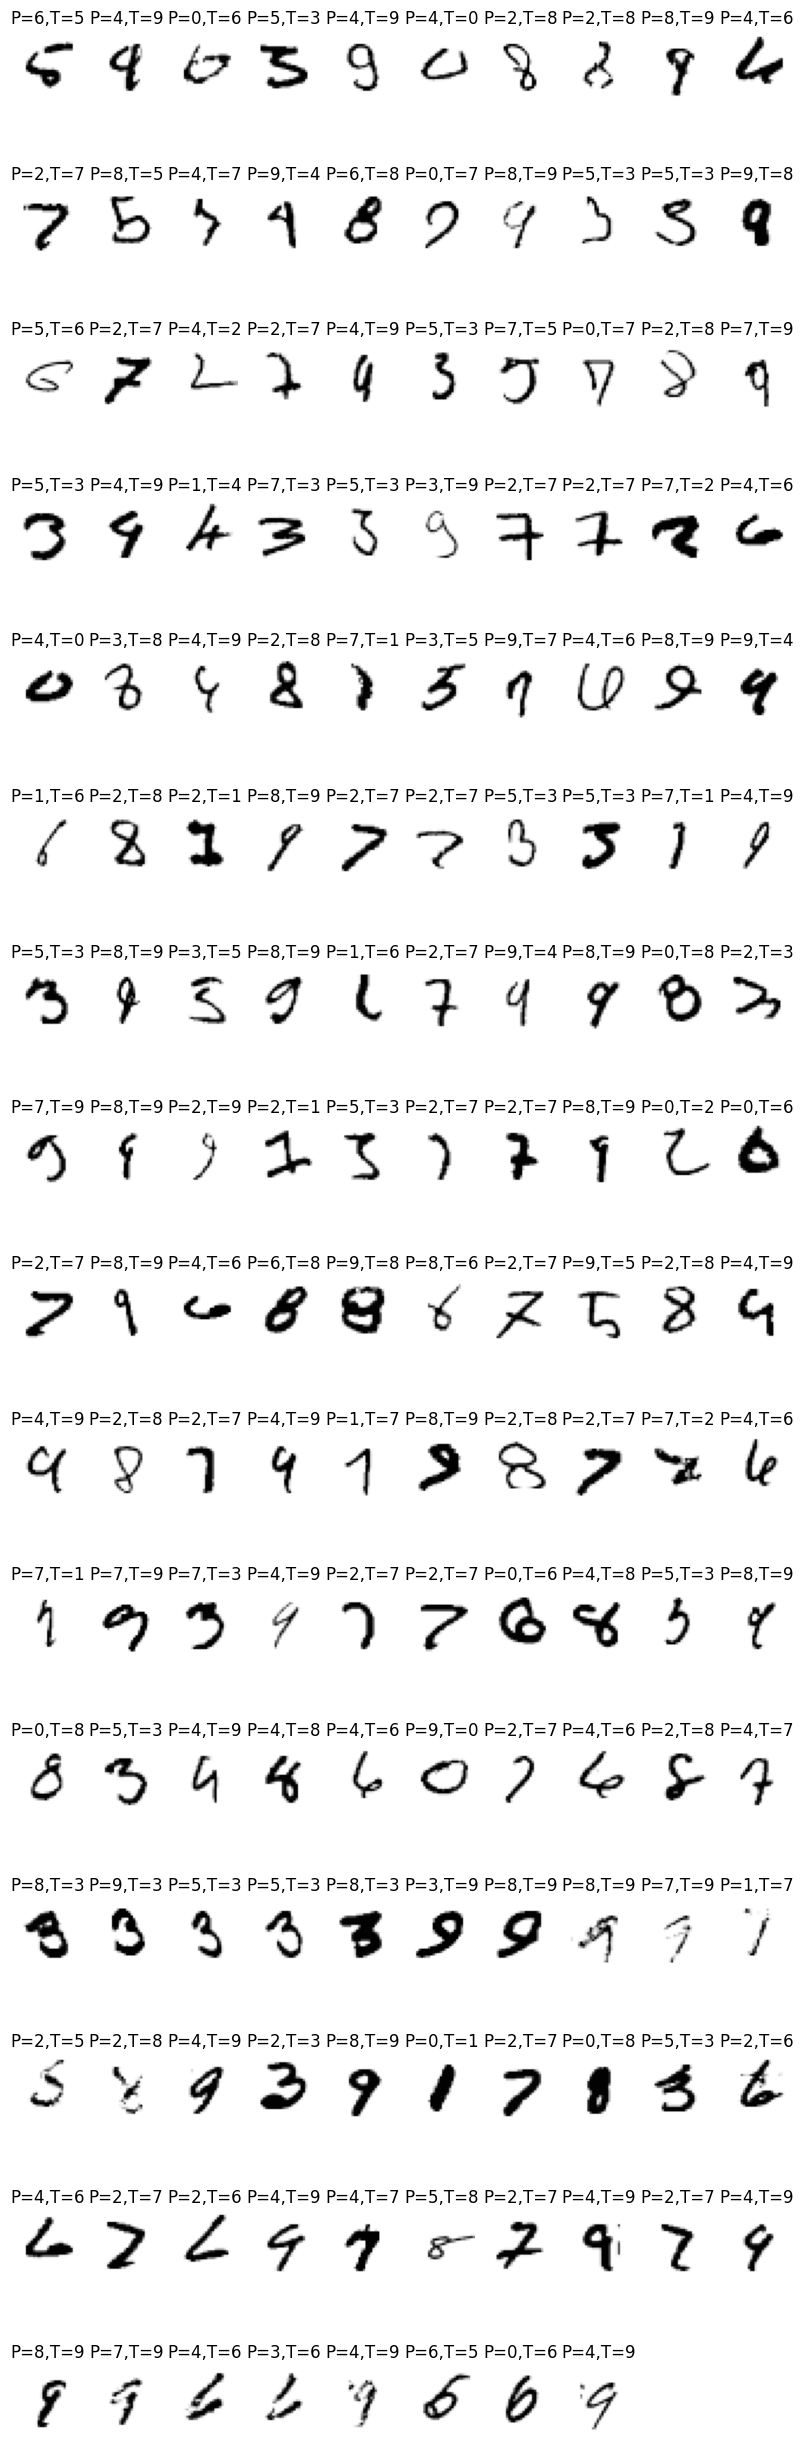

In [58]:
# Visualisation des mauvaises prédictions. Dans le titre P=prediction, T=label (T pour True)
ShowBadPredictions(Xtest,Y_pred,Ytest)

**Analyse des résultats**

**On remarque que nous avons une  très bonne précision sur un échantillon d'environ 1000 images par classe. En effet, les images de numéros restent assez basiques en terme de complexité, et offrent donc un entrainement suffisant au réseau de neuronnes pour pouvoir détecter les bons chiffres, le manque d'accuracy provient de la faible taille de la base de donnée. Sur les termes hors diagonaux, noius pouvons voir les erreurs de prédictions qui sont assez minimes comparants les chiffres sur la diagonale correspondant aux bonnes prédictions.**

Faire de même pour Fashion-MNIST


In [59]:
Xtrain1=np.array(XtrainFM);
Xtest1=np.array(XtestFM);
Ytrain1=YtrainFM
Ytest1=YtestFM

print('avant mise en format')
print("Xtrain1:"+ str(np.shape(Xtrain1)) + " , Ytrain1:" + str(np.shape(Ytrain1)))
print("Xtest1:"+ str(np.shape(Xtest1))+ " , Ytest1" + str(np.shape(Ytest1)))


# Mise en forme des données d'entrée
Xtrain1=np.array( Xtrain1.reshape((len(Ytrain1),28,28,1)) )
Xtest1=np.array(  Xtest1.reshape((len(Ytest1),28,28,1))   )

# Mise en forme des données de sortie
#attention ! : vous devez bien comprendre ce que font ces lignes de code
#              ... et comprendre pourquoi il faudra utiliser Ytest et non Ytest_nn pour la matrice de confusion !
Ytrain_nn1 = to_categorical(Ytrain1)
Ytest_nn1 = to_categorical(Ytest1)

print('après mise en format')
print("Xtrain1:"+ str(np.shape(Xtrain1)) + " , Ytrain_nn:" + str(np.shape(Ytrain_nn1)))
print("Xtest1:"+ str(np.shape(Xtest1))+ " , Ytest nn:" + str(np.shape(Ytest_nn1)))


avant mise en format
Xtrain1:(60000, 28, 28) , Ytrain1:(60000,)
Xtest1:(10000, 28, 28) , Ytest1(10000,)
après mise en format
Xtrain1:(60000, 28, 28, 1) , Ytrain_nn:(60000, 10)
Xtest1:(10000, 28, 28, 1) , Ytest nn:(10000, 10)


In [65]:
ModelClassifImage = Sequential()

ModelClassifImage = Sequential()
ModelClassifImage.add(Conv2D(16, kernel_size=(5, 5), strides=(1, 1), activation='relu', input_shape=(28,28,1)))
ModelClassifImage.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
ModelClassifImage.add(Conv2D(32, (3, 3), activation='relu'))
ModelClassifImage.add(MaxPooling2D(pool_size=(2, 2)))
ModelClassifImage.add(Conv2D(32, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
ModelClassifImage.add(Flatten())
ModelClassifImage.add(Dense(100, activation='relu', name='Coucheextraite'))
ModelClassifImage.add(Dense(40, activation='relu', name='Pouilly'))
ModelClassifImage.add(Dense(10, activation='softmax'))

# compile model
ModelClassifImage.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
ModelClassifImage.summary() # permet d'afficher l'architecture du réseaux, les noms et dimensions des couches, le nombre de paramètres du réseau.

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)                    │ (None, 24, 24, 16)          │             416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 12, 12, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 10, 10, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 5, 5, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 3, 3, 32)            │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 288)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Coucheextraite (Dense)               │ (None, 100)                 │          28,900 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Pouilly (Dense)                      │ (None, 40)                  │           4,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 10)                  │             410 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 47,654 (186.15 KB)

 Trainable params: 47,654 (186.15 KB)

 Non-trainable params: 0 (0.00 B)

In [61]:
Entrainement=False

if Entrainement :
  history = ModelClassifImage.fit(Xtrain1,Ytrain_nn1, epochs=10, batch_size=64,
                    validation_data=(Xtest1,Ytest_nn1), verbose=1)

In [62]:
#choisir le nom du fichier de poids qui sera sauvegardé dans le Drive
filename="CL&Co"
# Si vous relancez pour Fashion MNIST, il faut penser à changer le nom pour ne pas écraser le jeu de poids du réseau pour MNIST

if Entrainement :
  # evaluate model
  _, acc = ModelClassifImage.evaluate(Xtest1,Ytest_nn1)
  print('> %.3f' % (acc * 100.0))
  # save model parameters
  ModelClassifImage.save_weights("{}/{}.weights.h5".format(working_dir,filename))
  # learning curves
  summarize_diagnostics_classif(history,working_dir,filename)

else:
  # load model parameters
  filename="CL&Co"
  ModelClassifImage.load_weights("{}/{}.weights.h5".format(working_dir,filename))


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
classe:   0 nan
classe:   1 0.11427572951249344
classe:   2 nan
classe:   3 0.11089108910891089
classe:   4 nan
classe:   5 0.5949367088607594
classe:   6 nan
classe:   7 nan
classe:   8 nan
classe:   9 nan


<ipython-input-66-ef122361cc6b>:17: RuntimeWarning: invalid value encountered in scalar divide
  L.append(cm[i][i]/sum(cm[i][j] for j in range (len(cm))))


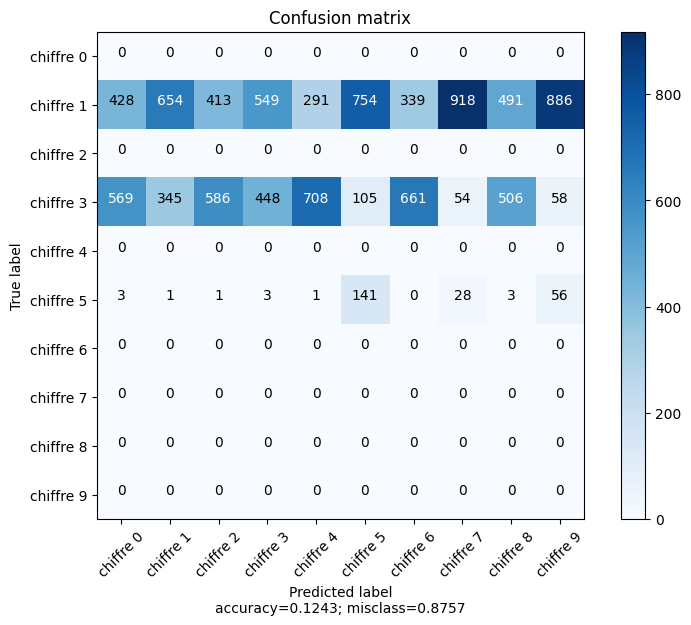

In [66]:
# Prédictions sur les données de test et  matrice de confusion
y_pred1=ModelClassifImage.predict(Xtest1)
Y_pred1 = np.argmax(y_pred1, 1) # Expliquez(commentez) ce point

cm=confusion_matrix(Y_pred1,Ytest1)

# MNIST
name_classes=['chiffre 0','chiffre 1','chiffre 2','chiffre 3','chiffre 4',
                  'chiffre 5','chiffre 6','chiffre 7','chiffre 8','chiffre 9']


# remarque : de même pour Fashion MNIST, nous pouvons nommer les classes
#name_classes=['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
#                'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
L = []
for i in range (len(cm)):
  L.append(cm[i][i]/sum(cm[i][j] for j in range (len(cm))))
  print('classe:  ',i,  L[-1])



Mytitle='Confusion matrix'
Mycmap='Blues'    #personnalisation de la couleur : https://matplotlib.org/2.0.2/examples/color/colormaps_reference.html  (par défaut = Blues)
plot_confusion_matrix(cm,target_names=name_classes,title=Mytitle,cmap=Mycmap,normalize=False)
# normalize : 'False' = résultat en nombre d'occurences , 'True' = resultat en proportion pour chaque classe

In [ ]:
# Visualisation des mauvaises prédictions. Dans le titre P=prediction, T=label (T pour True)
ShowBadPredictions(Xtest1,Y_pred1,Ytest1)

Output hidden; open in https://colab.research.google.com to view.

# Un mot sur le transfert d'appprentissage

**Extraire des caractéristiques à partir d'un réseau entrainé**

Nous allons pouvoir faire cela facilement. Ici nous voulons recupérer des caractéristiques en sortie de la couche dense (name="...") de ModelClassifImage pour le transferer vers un autre problème de classification (X,Ylabel) où la dimension de l'entrée X est la même.
C'est la base d'un transfert d'apprentissage (transfer learning) qui consiste à :
- Extraire des caractéristiques (données numériques, ou filtres si le réseau est coupé avant le flatten) en sortie d'une couche d'un réseau pré-entrainé (input X, output=Xfeatures), pour le transférer d'un problème vers un nouveau problème cible.
- Il suffit alors d'ajouter et d'entrainer un réseau de quelques couches pour répondre au nouveau problème cible de classification qui devient (input=Xfeatures,output=Ylabel).

Une autre étude intéressante est d'utiliser cette extraction de caractéristiques Xfeatures après une couche dense (données numériques) et comparer les performances entre :
- couches de classification (celles après l'extraction)
- algorithme de classification supervisé (k plus proches voisins par exemple)

Voic deux liens utiles pour votre culture sur le transfer learning

https://machinelearningmastery.com/how-to-use-transfer-learning-when-developing-convolutional-neural-network-models/

https://keras.io/guides/transfer_learning/

In [50]:
# chargement du modèle ModelClassifImage entraîné (avec donc son jeu de poids)
fileload="Achoisir"
ModelClassifImage.load_weights("{}/{}.weights.h5".format(working_dir,fileload))

# evaluate model
_, acc = ModelClassifImage.evaluate(Xtest1,Ytest_nn1)
print('> %.3f' % (acc * 100.0))
# pour vérification (nous devons retrouver l'accuracy de test précédente)

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


ValueError: A total of 3 objects could not be loaded. Example error message for object <Dense name=dense_3, built=True>:

The shape of the target variable and the shape of the target value in `variable.assign(value)` must match. variable.shape=(100, 100), Received: value.shape=(288, 100). Target variable: <KerasVariable shape=(100, 100), dtype=float32, path=sequential_5/dense_3/kernel>

List of objects that could not be loaded:
[<Dense name=dense_3, built=True>, <Dense name=dense_5, built=True>, <Dense name=dense_6, built=True>]

In [ ]:
# NewmodelCut = le modèle chargé, de la couche d'entrée à la couche "name="NomDeLaCouche"
# A COMPLETER : changer NomDeLaCouche en le nom de la couche Dense nommée.
NewModelCut=Model([ModelClassifImage.inputs],[ModelClassifImage.get_layer("Pouilly").output])

XtestFeatures=NewModelCut.predict(Xtest1)
XtrainFeatures=NewModelCut.predict(Xtrain1)
print(np.shape(XtestFeatures))

NewModelCut.summary()

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
(10000, 40)


Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 24, 24, 16)          │             416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 12, 12, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 10, 10, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 5, 5, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 3, 3, 32)            │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 288)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Briand (Dense)                       │ (None, 100)                 │          28,900 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Pouilly (Dense)                      │ (None, 40)                  │           4,040 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 47,244 (184.55 KB)

 Trainable params: 47,244 (184.55 KB)

 Non-trainable params: 0 (0.00 B)

# Projet - Partie 2

In [ ]:
#algorithme des KNN une fois les caractéristiques extraites ( ie une fois la dernière couche dense de 10 neuronnes)

# Importation de packages utiles


import sklearn.neighbors as knn                          # Algorithme de classification supervisée (k plus proches voisins)
import sklearn.cluster as clstr                          # Bibliothèque pour la classification non supervisée (clustering : clstr) dans laquelle se trouve l'algorithme K-means


# construction du modèle

nb_voisins=10 #choix du paramètre k=nombre de voisins
model= knn.KNeighborsClassifier(n_neighbors=nb_voisins)  # Remarque : par défaut n_neighbors=5, ici réglé à nb_voisins.

#fit du modèle sur la connaissance des N=100 données labélisées
model.fit(XtrainFeatures,Ytrain1)

# prédictions sur les tot-N=150-100=50 gardées pour les tests.
Ypred=model.predict(XtestFeatures)


# calcul de l'accuracy
err=0
Ntest= len(Ytest1)
for i in range(Ntest):
    if Ypred[i] != Ytest1[i] :  # si mauvaise prédiction :
            err += 1
print('erreurs = ',err,'/',Ntest,' donc accuracy = ',(Ntest-err)/Ntest*100,'%')

erreurs =  1044 / 10000  donc accuracy =  89.56 %


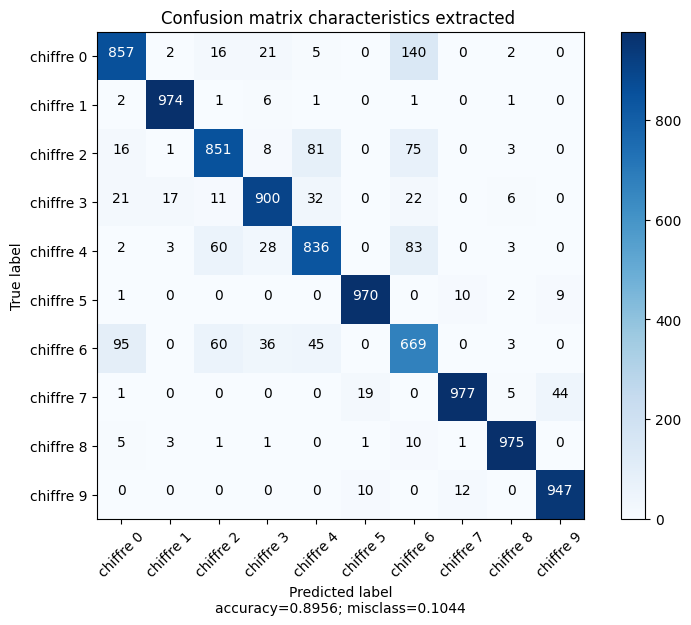

In [ ]:
#analyse des données à l'aide d'une matrice de confusion
from sklearn.metrics import confusion_matrix

cm1=confusion_matrix(Ypred,Ytest1)


# remarque : de même pour Fashion MNIST, nous pouvons nommer les classes
#name_classes=['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
#                'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


Mytitle='Confusion matrix characteristics extracted '
Mycmap='Blues'    #personnalisation de la couleur : https://matplotlib.org/2.0.2/examples/color/colormaps_reference.html  (par défaut = Blues)
plot_confusion_matrix(cm1,target_names=name_classes,title=Mytitle,cmap=Mycmap,normalize=False)
# normalize : 'False' = résultat en nombre d'occurences , 'True' = resultat en proportion pour chaque classe

**Comparaison avec la dernière couche de notre réseau: Les résultats sont assez similaires avce parfois des erreurs de prédictions un peu plus importantes. Par exemple, 140 (au lieu de 121)**

In [ ]:
#desnité = nb de voisins de la même classe

def OccurencesClasses(Labels,NbClasses):
  Occ=np.zeros(NbClasses,int)
  for i in range(len(Labels)):
    Occ[Labels[i]]+=1;
  return(Occ)
# on aurait s'est inpiré du programme ci-dessus

Good= [0,0,0,0,0,0,0,0,0,0,0]
Bad= [0,0,0,0,0,0,0,0,0,0,0]


for i in range(0,10000):
  Densite =model.predict_proba (XtestFeatures[i]. reshape (1 , -1)) # on récuppère la densité qui est un vecteur
  pred = np.argmax( Densite )# prediction
  nb_voisins=10
  ind = int(nb_voisins* np.max(Densite))
  if pred == Ytest1[i]:
    Good[ind] +=1
  else:
    Bad[ind] +=1
print(Good)
print(Bad)

#en fait les listes Good et Bad, c'est un moyen de montrer que lorsqu'il y a i voisin on a tant de bonnes reponses, tant de bonnes ereurs

[0, 0, 0, 5, 21, 127, 257, 277, 384, 738, 7147]
[0, 0, 0, 11, 69, 169, 200, 167, 152, 119, 157]


[0.3125, 0.23333333333333334, 0.42905405405405406, 0.562363238512035, 0.6238738738738738, 0.7164179104477612, 0.8611435239206534, 0.9785049288061336]


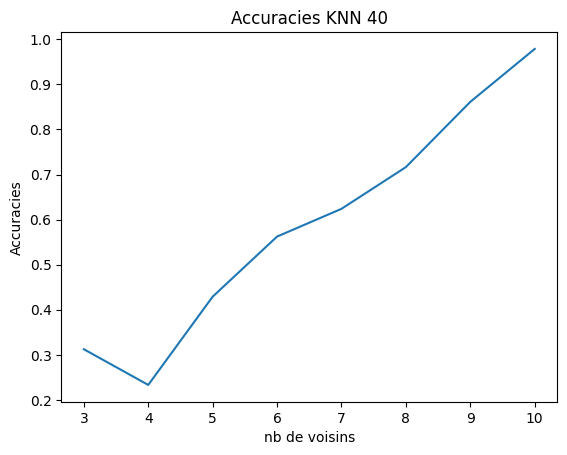

In [ ]:
veracite=[Good[k]/(Good[k]+Bad[k]) for k in range(3,len(Good))]
print(veracite)

X=[i for i in range(3,len(Good))]
Y = veracite
plt.xlabel("nb de voisins")
plt.ylabel("Accuracies")
plt.title("Accuracies KNN 40")
plt.plot(X,Y,)
plt.show()

Question4: *on a fait de même en coupant cette fois au niveau de la couche dense de 100 neuronnes*

In [ ]:
# chargement du modèle ModelClassifImage entraîné (avec donc son jeu de poids)
fileload=filename
ModelClassifImage.load_weights("{}/{}.weights.h5".format(working_dir,filename))

# evaluate model
_, acc = ModelClassifImage.evaluate(Xtest1,Ytest_nn1)
print('> %.3f' % (acc * 100.0))
# pour vérification (nous devons retrouver l'accuracy de test précédente)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8938 - loss: 0.3311
> 89.650


In [ ]:
# NewmodelCut = le modèle chargé, de la couche d'entrée à la couche "name="NomDeLaCouche"
# A COMPLETER : changer NomDeLaCouche en le nom de la couche Dense nommée.
NewModelCut=Model([ModelClassifImage.inputs],[ModelClassifImage.get_layer("Briand").output])

XtestFeatures1=NewModelCut.predict(Xtest1)
XtrainFeatures1=NewModelCut.predict(Xtrain1)
print(np.shape(XtestFeatures1))

NewModelCut.summary()

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
(10000, 100)


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 24, 24, 16)          │             416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 12, 12, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 10, 10, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 5, 5, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 3, 3, 32)            │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 288)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Briand (Dense)                       │ (None, 100)                 │          28,900 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 43,204 (168.77 KB)

 Trainable params: 43,204 (168.77 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#algorithme des KNN une fois les caractéristiques extraites ( ie une fois la dernière couche dense de 10 neuronnes)

# Importation de packages utiles


import sklearn.neighbors as knn                          # Algorithme de classification supervisée (k plus proches voisins)
import sklearn.cluster as clstr                          # Bibliothèque pour la classification non supervisée (clustering : clstr) dans laquelle se trouve l'algorithme K-means


# construction du modèle

nb_voisins=10 #choix du paramètre k=nombre de voisins
model= knn.KNeighborsClassifier(n_neighbors=nb_voisins)  # Remarque : par défaut n_neighbors=5, ici réglé à nb_voisins.

#fit du modèle sur la connaissance des N=100 données labélisées
model.fit(XtrainFeatures1,Ytrain1)

# prédictions sur les tot-N=150-100=50 gardées pour les tests.
Ypred=model.predict(XtestFeatures1)


# calcul de l'accuracy
err=0
Ntest= len(Ytest1)
for i in range(Ntest):
    if Ypred[i] != Ytest1[i] :  # si mauvaise prédiction :
            err += 1
print('erreurs = ',err,'/',Ntest,' donc accuracy = ',(Ntest-err)/Ntest*100,'%')

erreurs =  989 / 10000  donc accuracy =  90.11 %


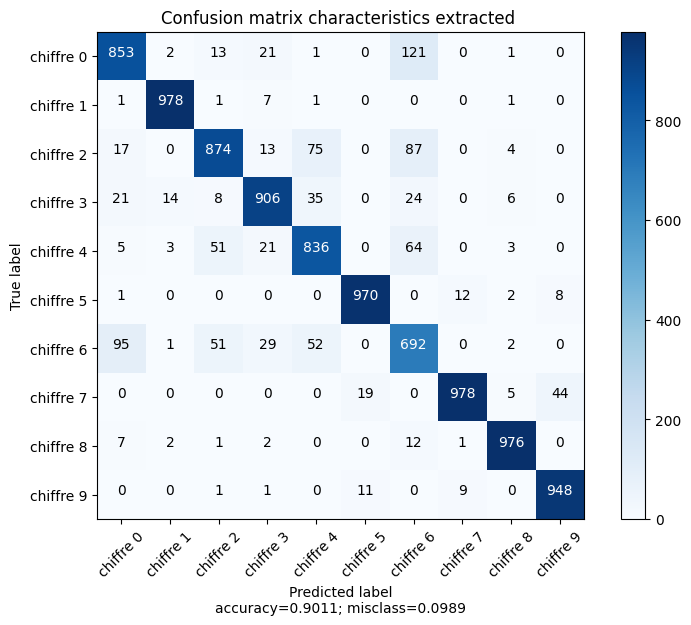

In [ ]:
#analyse des données à l'aide d'une matrice de confusion
from sklearn.metrics import confusion_matrix

cm1=confusion_matrix(Ypred,Ytest1)


# remarque : de même pour Fashion MNIST, nous pouvons nommer les classes
#name_classes=['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
#                'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


Mytitle='Confusion matrix characteristics extracted '
Mycmap='Blues'    #personnalisation de la couleur : https://matplotlib.org/2.0.2/examples/color/colormaps_reference.html  (par défaut = Blues)
plot_confusion_matrix(cm1,target_names=name_classes,title=Mytitle,cmap=Mycmap,normalize=False)
# normalize : 'False' = résultat en nombre d'occurences , 'True' = resultat en proportion pour chaque classe

In [ ]:
Good= [0,0,0,0,0,0,0,0,0,0,0]
Bad= [0,0,0,0,0,0,0,0,0,0,0]


for i in range(0,10000):
  Densite =model.predict_proba (XtestFeatures1[i]. reshape (1 , -1)) # on récuppère la densité qui est un vecteur
  pred = np.argmax( Densite )# prediction
  nb_voisins=10
  ind = int(nb_voisins* np.max(Densite))
  if pred == Ytest1[i]:
    Good[ind] +=1
  else:
    Bad[ind] +=1
print(Good)
print(Bad)

#en fait les listes Good et Bad, c'est un moyen de montrer que lorsqu'il y a i voisin on a tant de bonnes reponses, tant de bonnes ereurs

[0, 0, 0, 8, 41, 138, 253, 312, 431, 733, 7095]
[0, 0, 0, 22, 63, 176, 212, 164, 134, 116, 102]


[0.26666666666666666, 0.3942307692307692, 0.4394904458598726, 0.5440860215053763, 0.6554621848739496, 0.7628318584070797, 0.8633686690223793, 0.9858274280950396]


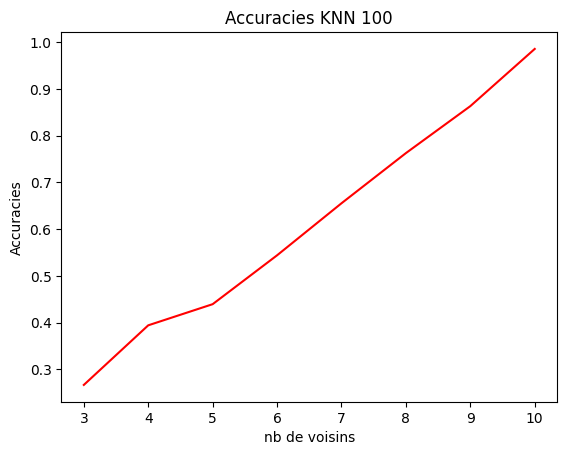

In [ ]:
veracite=[Good[k]/(Good[k]+Bad[k]) for k in range(3,len(Good))]
print(veracite)

X=[i for i in range(3,len(Good))]
Y = veracite
plt.xlabel("nb de voisins")
plt.ylabel("Accuracies")
plt.title("Accuracies KNN 100")
plt.plot(X,Y,'r')
plt.show()

## **Question 5 à Question 7**

In [21]:
# Importation de packages utiles
Xtrain2=np.array(XtrainFM);
Xtest2=np.array(XtestFM);
Ytrain2=YtrainFM
Ytest2=YtestFM


print('avant mise en format')
print("Xtrain2:"+ str(np.shape(Xtrain2)) + " , Ytrain2:" + str(np.shape(Ytrain2)))
print("Xtest2:"+ str(np.shape(Xtest2))+ " , Ytest2" + str(np.shape(Ytest2)))

# Mise en forme des données de sortie
#attention ! : vous devez bien comprendre ce que font ces lignes de code
#              ... et comprendre pourquoi il faudra utiliser Ytest et non Ytest_nn pour la matrice de confusion !
Ytrain_nn2 = to_categorical(Ytrain2)
Ytest_nn2 = to_categorical(Ytest2)

print('après mise en format')
print("Xtrain2:"+ str(np.shape(Xtrain2)) + " , Ytrain_nn:" + str(np.shape(Ytrain_nn2)))
print("Xtest2:"+ str(np.shape(Xtest2))+ " , Ytest nn:" + str(np.shape(Ytest_nn2)))





avant mise en format
Xtrain2:(60000, 28, 28) , Ytrain2:(60000,)
Xtest2:(10000, 28, 28) , Ytest2(10000,)
après mise en format
Xtrain2:(60000, 28, 28) , Ytrain_nn:(60000, 10)
Xtest2:(10000, 28, 28) , Ytest nn:(10000, 10)


In [67]:
# chargement du modèle ModelClassifImage entraîné (avec donc son jeu de poids)
fileload= filename
ModelClassifImage.load_weights("{}/{}.weights.h5".format(working_dir,filename))

# evaluate model
_, acc = ModelClassifImage.evaluate(Xtest1,Ytest_nn1)
print('> %.3f' % (acc * 100.0))
# pour vérification (nous devons retrouver l'accuracy de test précédente)

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8938 - loss: 0.3311
> 89.650


In [72]:

# NewmodelCut = le modèle chargé, de la couche d'entrée à la couche "name="NomDeLaCouche"
# A COMPLETER : changer NomDeLaCouche en le nom de la couche Dense nommée.
NewModelCut=Model([ModelClassifImage.inputs],[ModelClassifImage.get_layer("Coucheextraite").output])

XtestFeatures2=NewModelCut.predict(Xtest2)
XtrainFeatures2=NewModelCut.predict(Xtrain2)
print(np.shape(XtestFeatures1))

NewModelCut.summary()




313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
(10000, 100)


Model: "functional_48"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 24, 24, 16)          │             416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 12, 12, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 10, 10, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 5, 5, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 3, 3, 32)            │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 288)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Coucheextraite (Dense)               │ (None, 100)                 │          28,900 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 43,204 (168.77 KB)

 Trainable params: 43,204 (168.77 KB)

 Non-trainable params: 0 (0.00 B)

In [74]:

import sklearn.neighbors as knn                          # Algorithme de classification supervisée (k plus proches voisins)
import sklearn.cluster as clstr                          # Bibliothèque pour la classification non supervisée (clustering : clstr) dans laquelle se trouve l'algorithme K-means


# construction du modèle

nb_voisins=10 #choix du paramètre k=nombre de voisins
model= knn.KNeighborsClassifier(n_neighbors=nb_voisins)  # Remarque : par défaut n_neighbors=5, ici réglé à nb_voisins.

#fit du modèle sur la connaissance des N=100 données labélisées
model.fit(XtrainFeatures2,Ytrain2)

# prédictions sur les tot-N=150-100=50 gardées pour les tests.
Ypred=model.predict(XtestFeatures2)


# calcul de l'accuracy
err=0
Ntest= len(Ytest2)
for i in range(Ntest):
    if Ypred[i] != Ytest2[i] :  # si mauvaise prédiction :
            err += 1
print('erreurs = ',err,'/',Ntest,' donc accuracy = ',(Ntest-err)/Ntest*100,'%')

erreurs =  989 / 10000  donc accuracy =  90.11 %


In [92]:
#Extraction au niveau de la couche dense 100
#Création de notre petit réseau dense pour FashionMNIST

import numpy as np
from matplotlib import pyplot as plt
import random

import tensorflow as tf
import keras                                             # bibliothèque Python pour la création de réseaux de neurones (il est contenu dans tensorflow, d'où l'import précédent)
from keras.models import Sequential, Model               # pour créer un modèle (un réseau de neurones) sous Keras
from keras.layers import Dense, Dropout, Activation      # couches classiques d'un réseau dense
from keras.layers import Conv2D, MaxPooling2D,  Flatten  # pour réseau de convolution (si problème traité porte sur des images)
from keras.utils import to_categorical                   # pour mise en format des labels(sorties) dans le cas d'un problème de classification
from sklearn.metrics import confusion_matrix             # outil d'analyse des résultats pour un problème de classification

from keras.datasets import mnist,fashion_mnist


NewModel = Sequential()
NewModel.add(Dense(100, activation='relu',input_dim=100))
NewModel.add(Dense(40, activation='relu'))
NewModel.add(Dense(25,activation='relu'))
NewModel.add(Dense(10, activation='softmax'))


# compile model
NewModel.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
NewModel.summary() # permet d'afficher l'architecture du réseaux, les noms et dimensions des couches, le nombre de paramètres du réseau.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_24 (Dense)                     │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 40)                  │           4,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 25)                  │           1,025 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 10)                  │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,425 (60.25 KB)

 Trainable params: 15,425 (60.25 KB)

 Non-trainable params: 0 (0.00 B)

In [95]:
print(np.shape(XtrainFeatures2))
print(np.shape(Ytrain_nn2))
print(np.shape(XtestFeatures2))


(60000, 100)
(60000, 10)
(10000, 100)


In [96]:
Entrainement=True
NewModel.summary()
if Entrainement :
  history = NewModel.fit(XtrainFeatures2,Ytrain_nn2, epochs=10, batch_size=64,
                    validation_data=(XtestFeatures2,Ytest_nn2), verbose=1)

filename = "Q5partie2"

if Entrainement :
  # evaluate model
  _, acc = NewModel.evaluate(XtestFeatures2,Ytest_nn2)
  print('> %.3f' % (acc * 100.0))
  # save model parameters
  NewModel.save_weights("{}/{}.weights.h5".format(working_dir,filename))
  # learning curves
  summarize_diagnostics_classif(history,working_dir,filename)




Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_24 (Dense)                     │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 40)                  │           4,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 25)                  │           1,025 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 10)                  │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,427 (60.27 KB)

 Trainable params: 15,425 (60.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

Epoch 1/10


IndexError: list index out of range

In [ ]:
y_pred2 = NewModel.predict(XtestFeatures2)
Ypred2 = np.argmax(y_pred2, 1)
cm = confusion_matrix(Ypred2, Ytest2)

name_classes=['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

Mytitle='Confusion matrix characteristics extracted '
Mycmap='Blues'    #personnalisation de la couleur : https://matplotlib.org/2.0.2/examples/color/colormaps_reference.html  (par défaut = Blues)
plot_confusion_matrix(cm1,target_names=name_classes,title=Mytitle,cmap=Mycmap,normalize=False)
# normalize : 'False' = résultat en nombre d'occurences , 'True' = resultat en proportion pour chaque classe

# Projet - Partie 3